# Smart Email Agent v3: Advanced & Configurable

This notebook contains the advanced implementation of the email automation agent. It has been refactored for clarity, debugging, and robustness.

**Key Features:**
1.  **Externalized Configs**: All settings and prompts are managed in `config.ini` and `prompts.ini`.
2.  **Tool-Augmented Drafting**: The agent uses a simulated knowledge base to answer support questions.
3.  **Advanced Feedback Loop**: A "Critique & Revise" cycle for human collaboration.
4.  **Resilience**: SQLite checkpointing allows the agent to recover from crashes.
5.  **Clarity**: Broken-down cells, detailed documentation, and a visual graph diagram.

---

## 1. Setup and Installation

This cell installs all the required Python libraries for the project.

In [1]:
%pip install langgraph langchain_openai langchain_google_genai langgraph-checkpoint-sqlite ipykernel python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google

---

## 2. Configuration Loading

This section handles loading all external configurations. It uses `configparser` to read settings from `config.ini` and `prompts.ini`, and `dotenv` to load secure API keys from a `.env` file. This separation of configuration from code is a best practice.

In [1]:
import os
import configparser
from dotenv import load_dotenv
import sqlite3

try:
    # Load environment variables from a .env file for API keys
    load_dotenv("dev.env", override=True)
    print("API keys loaded from .env file.")

    # Load settings from config.ini
    config = configparser.ConfigParser()
    config.read('config.ini')

    ENABLE_MULTI_MODEL_DRAFTING = config.getboolean('FeatureFlags', 'enable_multi_model_drafting')
    ENABLE_KNOWLEDGE_BASE_TOOL = config.getboolean('FeatureFlags', 'enable_knowledge_base_tool')
    CLASSIFICATION_MODEL = config.get('Models', 'classification_model')
    EVALUATOR_MODEL = config.get('Models', 'evaluator_model')
    REVISER_MODEL = config.get('Models', 'reviser_model')
    PRIMARY_DRAFTING_MODEL_PROVIDER = config.get('Models', 'primary_drafting_model_provider')
    PRIMARY_DRAFTING_MODEL_NAME_OPENAI = config.get('Models', 'primary_drafting_model_name_openai')
    PRIMARY_DRAFTING_MODEL_NAME_GOOGLE = config.get('Models', 'primary_drafting_model_name_google')
    SECONDARY_DRAFTING_MODEL_PROVIDER = config.get('Models', 'secondary_drafting_model_provider')
    SECONDARY_DRAFTING_MODEL_NAME_GOOGLE = config.get('Models', 'secondary_drafting_model_name_google')
    CLASSIFICATION_TEMPERATURE = config.getfloat('Temperatures', 'classification')
    DRAFTING_TEMPERATURE = config.getfloat('Temperatures', 'drafting')
    EVALUATOR_TEMPERATURE = config.getfloat('Temperatures', 'evaluator')
    REVISER_TEMPERATURE = config.getfloat('Temperatures', 'reviser')
    MAX_CLASSIFICATION_ATTEMPTS = config.getint('AgentSettings', 'max_classification_attempts')
    SQLITE_DB_PATH = config.get('Database', 'sqlite_db_path')
    print("Settings from config.ini loaded.")

    # Load prompts from prompts.ini
    prompts = configparser.ConfigParser()
    prompts.read('prompts.ini')
    CLASSIFIER_PROMPT = prompts.get('Prompts', 'classifier')
    DRAFTER_BASIC_PROMPT = prompts.get('Prompts', 'drafter_basic')
    DRAFTER_WITH_TOOL_PROMPT = prompts.get('Prompts', 'drafter_with_tool_result')
    EVALUATOR_PROMPT = prompts.get('Prompts', 'evaluator')
    REVISER_PROMPT = prompts.get('Prompts', 'reviser')
    print("Prompts from prompts.ini loaded.")

except FileNotFoundError as e:
    print(f"Error: Configuration file not found - {e}. Please ensure 'config.ini' and 'prompts.ini' are in the same directory.")
except KeyError as e:
    print(f"Error: Missing configuration key - {e}. Please check your .ini files.")

API keys loaded from .env file.
Settings from config.ini loaded.
Prompts from prompts.ini loaded.


---

## 3. Agent State and Tool Definition

Here, we define the `EmailWorkflowState`, which is the central data structure (or "memory") that gets passed between all the nodes in our graph. We also define our first tool, `search_knowledge_base`, which simulates looking up information.

In [2]:
from typing import TypedDict, Literal
from langchain_core.tools import tool

# The state is a TypedDict, which provides type hints for better code clarity.
class EmailWorkflowState(TypedDict):
    email_content: str
    classification: Literal["sales_inquiry", "support_request", "general_question", "spam", "invalid"]
    knowledge_base_result: str
    draft_openai: str
    draft_gemini: str
    final_draft: str
    human_action: Literal["approve", "edit", "reject", ""]
    human_feedback: str
    error_message: str
    classification_attempts: int

In [3]:
# The @tool decorator makes this Python function available to the agent as a tool.
@tool
def search_knowledge_base(query: str) -> str:
    """Simulates searching a knowledge base for a solution to a user's problem."""
    knowledge_base = {
        "password reset": "To reset your password, please go to the 'Account Settings' page and click 'Forgot Password'.",
        "login issue": "Common login issues can be resolved by clearing your browser cache and cookies.",
        "account locked": "If your account is locked, please contact support directly at support@example.com for manual verification."
    }
    for keyword, solution in knowledge_base.items():
        if keyword in query.lower():
            return solution
    return "No specific solution found."

print("Agent state and tools defined.")

Agent state and tools defined.


In [4]:
# The @tool decorator makes this Python function available to the agent as a tool.
@tool
def search_knowledge_base_llm(query: str) -> str:
    """
    Uses an LLM to reason over a knowledge base and find a solution to a user's problem.
    """
    # The knowledge base is now just a string that will be part of the prompt.
    knowledge_base_text = """
    Article 1: Password Reset
    Solution: To reset your password, please go to the 'Account Settings' page and click 'Forgot Password'.

    Article 2: Common Login Issues
    Solution: Common login issues can be resolved by clearing your browser cache and cookies.

    Article 3: Locked Accounts
    Solution: If your account is locked, please contact support directly at support@example.com for manual verification.
    """

    # Create a specific LLM for this tool
    # Using a fast model like gpt-4o-mini is great for this.
    tool_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

    prompt = f"""
    You are an expert at reading a knowledge base and finding the correct answer to a user's question.
    Read the user's query and the provided knowledge base articles below.
    Find the single most relevant article and return ONLY its solution.
    If no article is directly relevant, return "No specific solution found."

    --- KNOWLEDGE BASE ---
    {knowledge_base_text}
    ---

    USER QUERY:
    "{query}"
    """

    try:
        response = tool_llm.invoke(prompt)
        return response.content
    except Exception as e:
        print(f"Error using the knowledge base LLM: {e}")
        return "Error searching knowledge base."

print("Agent state and LLM-powered tool defined.")

Agent state and LLM-powered tool defined.


---

## 4. Agent Node Definitions

Each function below represents a **node** in our graph. A node is a single step of work. We've broken them down into logical groups for clarity.

### 4.1 - Classification and Validation Nodes

In [5]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

# Helper to load models dynamically based on config
def get_model(provider: str, model_name_openai: str, model_name_google: str, temperature: float):
    try:
        if provider == "openai": return ChatOpenAI(model=model_name_openai, temperature=temperature)
        if provider == "google": return ChatGoogleGenerativeAI(model=model_name_google, temperature=temperature)
        raise ValueError(f"Unsupported provider: {provider}")
    except Exception as e:
        print(f"Error loading model {provider}: {e}")
        return None



In [6]:
print("MAX_CLASSIFICATION_ATTEMPTS:", MAX_CLASSIFICATION_ATTEMPTS)
print("CLASSIFIER_PROMPT:", CLASSIFIER_PROMPT)

MAX_CLASSIFICATION_ATTEMPTS: 2
CLASSIFIER_PROMPT: You are an expert email classifier. Your job is to read the email content and classify it into ONE of the following categories: 'sales_inquiry', 'support_request', 'general_question', 'spam'. Return ONLY the category name and nothing else. Do not add explanations or punctuation.


In [7]:
def classify_email_node(state: EmailWorkflowState):
    import random
    randn = random.random()
    print("randn: ", randn)
    if simulate_crash and randn < 0.5:
        print("!!! SIMULATING A RANDOM CRASH -classify_email_node !!!")
        raise ConnectionError("Simulated random network failure!")
    # --- END SIMULATION LOGIC ---


    print("--- NODE: Classifying Email ---")
    attempts = state.get("classification_attempts", 0) + 1
    if attempts > MAX_CLASSIFICATION_ATTEMPTS:
        return {"classification": "invalid", "error_message": f"Classification failed after {MAX_CLASSIFICATION_ATTEMPTS} attempts."}

    llm = get_model("openai", CLASSIFICATION_MODEL, "", CLASSIFICATION_TEMPERATURE)
    if not llm: return {"error_message": "Classifier model failed to load."}

    prompt = f'{CLASSIFIER_PROMPT}\n\nEmail Content: "{state["email_content"]}"'
    try:
        response = llm.invoke(prompt)
        classification = response.content.strip().lower()
        print(f"DEBUG: Attempt {attempts} -> Classification: '{classification}'")
        return {"classification": classification, "classification_attempts": attempts}
    except Exception as e:
        print(f"Error during classification: {e}")
        return {"error_message": str(e)}



In [8]:
def validate_classification_node(state: EmailWorkflowState):
    import random
    randn = random.random()
    print("randn: ", randn)
    if simulate_crash and randn < 0.5:
        print("!!! SIMULATING A RANDOM CRASH -validate_classification_node !!!")
        raise ConnectionError("Simulated random network failure!")
    # --- END SIMULATION LOGIC ---

    print("--- NODE: Validating Classification ---")
    classification = state.get("classification")
    valid_categories = ["sales_inquiry", "support_request", "general_question", "spam"]
    if classification in valid_categories:
        print(f"DEBUG: Validation successful for category '{classification}'.")
        return {"error_message": ""}
    else:
        print(f"DEBUG: Validation FAILED for category '{classification}'.")
        return {"error_message": f"Invalid classification: {classification}"}

### 4.2 - Tool and Drafting Nodes

In [9]:
def knowledge_base_tool_node(state: EmailWorkflowState):
    print("--- NODE: Searching Knowledge Base ---")
    #result = search_knowledge_base.invoke({"query": state['email_content']})
    result = search_knowledge_base_llm.invoke({"query": state['email_content']})
    print(f"DEBUG: Knowledge Base Result: '{result}'")
    return {"knowledge_base_result": result}



In [10]:
print("DRAFTER_WITH_TOOL_PROMPT: ", DRAFTER_WITH_TOOL_PROMPT)

DRAFTER_WITH_TOOL_PROMPT:  You are a helpful and professional support assistant. A user has a support request, and you have the following information from our internal knowledge base. Use this information to draft a helpful reply to the user's email. Be direct and incorporate the knowledge base solution into your response.


In [11]:
def drafting_node(state: EmailWorkflowState):
    import random
    randn = random.random()
    print("randn: ", randn)
    if simulate_crash and randn < 0.5:
        print("!!! SIMULATING A RANDOM CRASH -drafting_node !!!")
        raise ConnectionError("Simulated random network failure!")
    # --- END SIMULATION LOGIC ---

    print("--- NODE: Drafting Reply ---")
    email_content = state['email_content']
    kb_result = state.get('knowledge_base_result')

    base_prompt = DRAFTER_WITH_TOOL_PROMPT + f"\n\nKNOWLEDGE BASE INFO:\n{kb_result}\n\nUSER EMAIL:\n{email_content}" if kb_result else DRAFTER_BASIC_PROMPT + f"\n\nEMAIL:\n{email_content}"

    drafts = {}
    try:
        if not ENABLE_MULTI_MODEL_DRAFTING:
            print("DEBUG: Single model drafting mode.")
            llm = get_model(PRIMARY_DRAFTING_MODEL_PROVIDER, PRIMARY_DRAFTING_MODEL_NAME_OPENAI, PRIMARY_DRAFTING_MODEL_NAME_GOOGLE, DRAFTING_TEMPERATURE)
            drafts["final_draft"] = llm.invoke(base_prompt).content
        else:
            print("DEBUG: Multi-model drafting mode.")
            openai_llm = get_model("openai", PRIMARY_DRAFTING_MODEL_NAME_OPENAI, "", DRAFTING_TEMPERATURE)
            drafts["draft_openai"] = openai_llm.invoke(base_prompt).content
            gemini_llm = get_model("google", "", SECONDARY_DRAFTING_MODEL_NAME_GOOGLE, DRAFTING_TEMPERATURE)
            drafts["draft_gemini"] = gemini_llm.invoke(base_prompt).content
        return drafts
    except Exception as e:
        print(f"Error during drafting: {e}")
        return {"error_message": str(e)}

### 4.3 - Evaluation and Revision Nodes

In [12]:
def evaluate_drafts_node(state: EmailWorkflowState):
    print("--- NODE: Evaluating Drafts ---")
    evaluator_llm = get_model("openai", EVALUATOR_MODEL, "", EVALUATOR_TEMPERATURE)
    prompt = f'{EVALUATOR_PROMPT}\n\nORIGINAL EMAIL: {state["email_content"]}\n\nDRAFT A: {state["draft_openai"]}\n\nDRAFT B: {state["draft_gemini"]}'
    try:
        final_draft = evaluator_llm.invoke(prompt).content
        print("DEBUG: Evaluator selected a final draft.")
        return {"final_draft": final_draft}
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return {"error_message": str(e), "final_draft": state["draft_openai"]} # Fallback to primary draft



In [13]:
def reviser_node(state: EmailWorkflowState):
    print("--- NODE: Revising Draft ---")
    reviser_llm = get_model("openai", REVISER_MODEL, "", REVISER_TEMPERATURE)
    prompt = f'{REVISER_PROMPT}\n\nORIGINAL DRAFT:\n{state["final_draft"]}\n\nUSER FEEDBACK:\n{state["human_feedback"]}'
    try:
        revised_draft = reviser_llm.invoke(prompt).content
        print("DEBUG: Revision complete.")
        return {"final_draft": revised_draft, "human_feedback": "", "human_action": ""}
    except Exception as e:
        print(f"Error during revision: {e}")
        return {"error_message": str(e)}

### 4.4 - Final State Nodes

In [14]:
def human_review_node(state: EmailWorkflowState):
    print("--- NODE: Awaiting Human Review ---")
    return {}

def send_email_node(state: EmailWorkflowState):
    print("--- NODE: Sending Email ---")
    return {}

def spam_or_invalid_node(state: EmailWorkflowState):
    print("--- NODE: Spam or Invalid Classification ---")
    return {}

---

## 5. Graph Construction and Visualization

Here, we wire all the nodes and conditional edges together into a `StateGraph`. We then compile it with our SQLite checkpointer. Finally, we'll visualize the graph structure to see the complete workflow.

In [15]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import Image, display, Markdown



In [16]:
# Conditional Edge Functions
def route_after_validation(state: EmailWorkflowState):
    if state.get("error_message"): return "classify_email"
    classification = state["classification"]
    if classification == "spam": return "handle_spam_or_invalid"
    if classification == "support_request" and ENABLE_KNOWLEDGE_BASE_TOOL: return "search_knowledge_base"
    return "draft_reply"



In [17]:
simulate_crash = False

def route_after_drafting(state: EmailWorkflowState):
    import random
    randn = random.random()
    print("randn: ", randn)
    if simulate_crash and randn < 0.5:
        print("!!! SIMULATING A RANDOM CRASH -route_after_drafting !!!")
        raise ConnectionError("Simulated random network failure!")
    # --- END SIMULATION LOGIC ---

    return "evaluate_drafts" if ENABLE_MULTI_MODEL_DRAFTING else "human_review"



In [18]:
import random

# This flag will control our simulation.
simulate_crash = False

def route_after_review(state: EmailWorkflowState):
    action = state.get("human_action")

    if action == "approve":
        # --- CRASH SIMULATION LOGIC ---
        # If the simulation is active, randomly fail 50% of the time.
        randn = random.random()
        print("randn: ", randn)
        if simulate_crash and randn < 0.5:
            print("!!! SIMULATING A RANDOM CRASH !!!")
            raise ConnectionError("Simulated random network failure! - route_after_review")
        # --- END SIMULATION LOGIC ---
        return "send_email"

    if action == "edit":
        return "revise_draft"

    return END # Reject

In [19]:
# Graph Definition
memory = SqliteSaver(conn=sqlite3.connect(SQLITE_DB_PATH, check_same_thread=False))
workflow = StateGraph(EmailWorkflowState)



In [20]:
workflow.add_node("classify_email", classify_email_node)
workflow.add_node("validate_classification", validate_classification_node)
workflow.add_node("search_knowledge_base", knowledge_base_tool_node)
workflow.add_node("draft_reply", drafting_node)
workflow.add_node("evaluate_drafts", evaluate_drafts_node)
workflow.add_node("revise_draft", reviser_node)
workflow.add_node("human_review", human_review_node)
workflow.add_node("send_email", send_email_node)
workflow.add_node("handle_spam_or_invalid", spam_or_invalid_node)



In [21]:
workflow.add_edge(START, "classify_email")
workflow.add_edge("classify_email", "validate_classification")
workflow.add_conditional_edges("validate_classification", route_after_validation, {
    "classify_email": "classify_email", "search_knowledge_base": "search_knowledge_base",
    "draft_reply": "draft_reply", "handle_spam_or_invalid": "handle_spam_or_invalid"
})
workflow.add_edge("search_knowledge_base", "draft_reply")
workflow.add_conditional_edges("draft_reply", route_after_drafting, {"evaluate_drafts": "evaluate_drafts", "human_review": "human_review"})
workflow.add_edge("evaluate_drafts", "human_review")
workflow.add_edge("revise_draft", "human_review")
workflow.add_conditional_edges("human_review", route_after_review, {"send_email": "send_email", "revise_draft": "revise_draft", END: END})
workflow.add_edge("send_email", END)
workflow.add_edge("handle_spam_or_invalid", END)



In [22]:
app = workflow.compile(checkpointer=memory)
print("Advanced graph compiled successfully!")



Advanced graph compiled successfully!


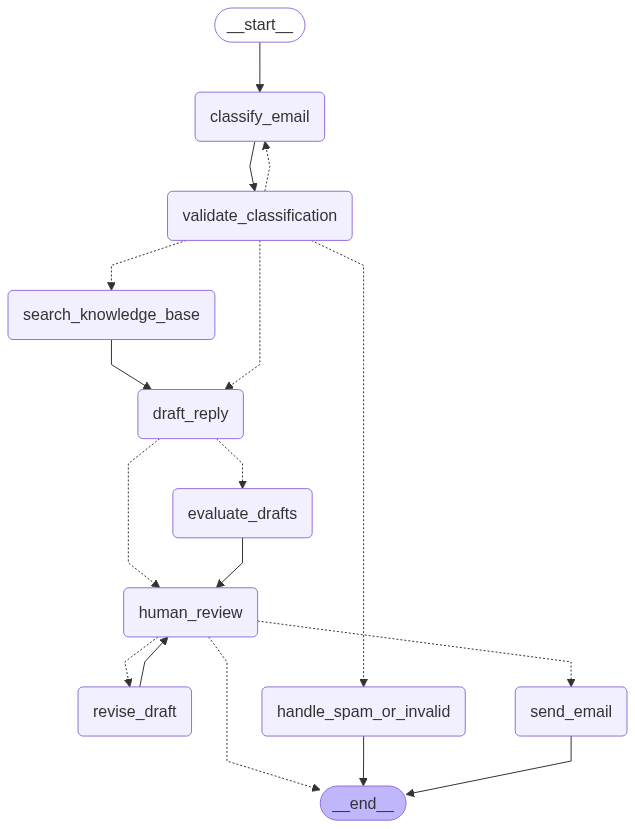

In [23]:
# Visualize the graph
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

---

## 6. Scenario 1: Tool-Augmented Support Ticket

We process a support email. The agent will use the `search_knowledge_base` tool to find a solution and incorporate it into the draft.

In [24]:
# Each email processing task is treated as a separate "thread" in our stateful agent.
# We generate a unique ID (UUID) for this thread to ensure its conversation history
# is saved and managed separately in the SQLite database by the checkpointer.

# Think of this as creating a unique "case file number" for this email.
# It allows the agent to save its progress and pick up where it left off for this specific case.

import uuid

thread_id_1 = str(uuid.uuid4())

In [25]:
config_1 = {"configurable": {"thread_id": thread_id_1}}
print(config_1)

{'configurable': {'thread_id': '815e97bd-2fd9-4922-9aab-ebafe3dc55e3'}}


In [26]:
email_content_1 = "Hi, I'm having a login issue and can't access my account. Can you help?"

In [27]:
initial_state_1 = {"email_content": email_content_1, "classification_attempts": 0}

In [28]:
print(f"--- Starting Scenario 1: Support Ticket (Thread ID: {thread_id_1}) ---")

--- Starting Scenario 1: Support Ticket (Thread ID: 815e97bd-2fd9-4922-9aab-ebafe3dc55e3) ---


In [29]:
# ======================================================================================
# This cell invokes the agent and runs the workflow, now with detailed logging.
#
# How it works:
# 1. `app.stream()` executes the graph, yielding an 'event' for each completed node.
# 2. Each 'event' is a dictionary where the key is the name of the node that just ran,
#    and the value is the full state of the workflow *after* that node's execution.
# 3. We loop through this dictionary to print which node ran and what the state looks like now.
# ======================================================================================
for event in app.stream(initial_state_1, config_1):
    # The 'event' dictionary has one key: the name of the node that just ran
    for node_name, updated_state in event.items():
        print(f"--- Output from Node: '{node_name}' ---")
        print("Current State:")
        # Print the key-value pairs from the state dictionary for clarity
        if not updated_state is None and len(updated_state) > 0:
          for key, value in updated_state.items():
              print(f"  - {key}: {value}")
          print("\n")

print("--- Workflow Paused for Human Review ---")

--- NODE: Classifying Email ---
DEBUG: Attempt 1 -> Classification: 'support_request'
--- Output from Node: 'classify_email' ---
Current State:
  - classification: support_request
  - classification_attempts: 1


--- NODE: Validating Classification ---
DEBUG: Validation successful for category 'support_request'.
--- Output from Node: 'validate_classification' ---
Current State:
  - error_message: 


--- NODE: Searching Knowledge Base ---
DEBUG: Knowledge Base Result: 'Common login issues can be resolved by clearing your browser cache and cookies.'
--- Output from Node: 'search_knowledge_base' ---
Current State:
  - knowledge_base_result: Common login issues can be resolved by clearing your browser cache and cookies.


--- NODE: Drafting Reply ---
DEBUG: Single model drafting mode.
--- Output from Node: 'draft_reply' ---
Current State:
  - final_draft: Subject: Re: Login Issue Assistance

Hi [User's Name],

Thank you for reaching out regarding your login issue. I understand how frustrat

### Debug & Approve the Draft

Let's inspect the state and then approve the draft to complete the workflow.

In [160]:
current_state = app.get_state(config_1)
print(current_state)

StateSnapshot(values={'email_content': "Hi, I'm having a login issue and can't access my account. Can you help?", 'classification': 'support_request', 'knowledge_base_result': 'Solution: Common login issues can be resolved by clearing your browser cache and cookies.', 'final_draft': 'Subject: Re: Login Issue Assistance\n\nHi [User\'s Name],\n\nThank you for reaching out regarding your login issue. I understand how important it is to access your account.\n\nA common solution for login problems is to clear your browser\'s cache and cookies. This can often resolve any issues related to stored data that may be causing the login problem.\n\nHere’s how you can clear your cache and cookies:\n\n1. Open your browser settings.\n2. Look for the option to clear browsing data or history.\n3. Select "Cookies and other site data" and "Cached images and files."\n4. Click on "Clear data."\n\nAfter doing this, please try logging in again. If you continue to experience issues, feel free to reply to this 

In [161]:
final_draft = current_state.values.get('final_draft', 'Draft not available.')

print(final_draft)

Subject: Re: Login Issue Assistance

Hi [User's Name],

Thank you for reaching out regarding your login issue. I understand how important it is to access your account.

A common solution for login problems is to clear your browser's cache and cookies. This can often resolve any issues related to stored data that may be causing the login problem.

Here’s how you can clear your cache and cookies:

1. Open your browser settings.
2. Look for the option to clear browsing data or history.
3. Select "Cookies and other site data" and "Cached images and files."
4. Click on "Clear data."

After doing this, please try logging in again. If you continue to experience issues, feel free to reply to this email, and I'll be glad to assist you further.

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]  


In [162]:
display(Markdown("### Pending Draft for Approval"))
display(Markdown(f"```\n{final_draft}\n```"))

### Pending Draft for Approval

```
Subject: Re: Login Issue Assistance

Hi [User's Name],

Thank you for reaching out regarding your login issue. I understand how important it is to access your account.

A common solution for login problems is to clear your browser's cache and cookies. This can often resolve any issues related to stored data that may be causing the login problem.

Here’s how you can clear your cache and cookies:

1. Open your browser settings.
2. Look for the option to clear browsing data or history.
3. Select "Cookies and other site data" and "Cached images and files."
4. Click on "Clear data."

After doing this, please try logging in again. If you continue to experience issues, feel free to reply to this email, and I'll be glad to assist you further.

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]  
```

In [163]:
# Approve the draft
app.update_state(config_1, {"human_action": "approve"})

{'configurable': {'thread_id': '6c770cdc-4395-4d1d-a71d-1829da7cc184',
  'checkpoint_ns': '',
  'checkpoint_id': '1f072ca6-3c9c-65d3-8014-5b95b78fdbf1'}}

In [164]:
print("\n--- Resuming workflow after approval ---")
for _ in app.stream(None, config_1):
    pass


--- Resuming workflow after approval ---
--- NODE: Sending Email ---


In [165]:
final_state = app.get_state(config_1)
display(Markdown("### Final Sent Email"))
display(Markdown(f"```\n{final_state.values.get('final_draft')}\n```"))

### Final Sent Email

```
Subject: Re: Login Issue Assistance

Hi [User's Name],

Thank you for reaching out regarding your login issue. I understand how important it is to access your account.

A common solution for login problems is to clear your browser's cache and cookies. This can often resolve any issues related to stored data that may be causing the login problem.

Here’s how you can clear your cache and cookies:

1. Open your browser settings.
2. Look for the option to clear browsing data or history.
3. Select "Cookies and other site data" and "Cached images and files."
4. Click on "Clear data."

After doing this, please try logging in again. If you continue to experience issues, feel free to reply to this email, and I'll be glad to assist you further.

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]  
```

---

## 7. Scenario 2: Critique & Revise Loop

Here, we'll provide feedback on a draft, forcing the agent into the `reviser_node` before final approval.

### Step 1: Initial Draft and Request for Edit

In [166]:
thread_id_2 = str(uuid.uuid4())
config_2 = {"configurable": {"thread_id": thread_id_2}}
email_content_2 = "Can you tell me about your refund policy?"
initial_state_2 = {"email_content": email_content_2, "classification_attempts": 0}

In [167]:
print(f"--- Starting Scenario 2: Critique & Revise (Thread ID: {thread_id_2}) ---")
for _ in app.stream(initial_state_2, config_2):
    pass

--- Starting Scenario 2: Critique & Revise (Thread ID: 3213b0bd-bc70-4e3e-b064-b93ec9ab8343) ---
--- NODE: Classifying Email ---
DEBUG: Attempt 1 -> Classification: 'general_question'
--- NODE: Validating Classification ---
DEBUG: Validation successful for category 'general_question'.
--- NODE: Drafting Reply ---
DEBUG: Single model drafting mode.
--- NODE: Awaiting Human Review ---


In [168]:
current_state_2 = app.get_state(config_2)
draft_to_revise = current_state_2.values.get('final_draft', '')
display(Markdown("### Initial Draft for Review"))
display(Markdown(f"```\n{draft_to_revise}\n```"))

### Initial Draft for Review

```
Subject: Re: Inquiry About Refund Policy

Dear [Recipient's Name],

Thank you for reaching out to us regarding our refund policy. We appreciate your interest.

Our refund policy allows for refunds within [insert time frame, e.g., 30 days] of purchase, provided that the item is in its original condition and packaging. To initiate a refund, please contact our customer service team at [insert contact information] with your order details, and we will guide you through the process.

If you have any further questions or need assistance, please feel free to ask.

Best regards,

[Your Name]  
[Your Position]  
[Your Company]  
[Your Contact Information]  
```

In [169]:
feedback = "This is a good start, but can you make the tone a bit more friendly and add a closing like 'Best regards, The Team'?"
print(f"\n--- Requesting edit with feedback: '{feedback}' ---")
app.update_state(config_2, {"human_action": "edit", "human_feedback": feedback})


--- Requesting edit with feedback: 'This is a good start, but can you make the tone a bit more friendly and add a closing like 'Best regards, The Team'?' ---


{'configurable': {'thread_id': '3213b0bd-bc70-4e3e-b064-b93ec9ab8343',
  'checkpoint_ns': '',
  'checkpoint_id': '1f072ca8-6873-6f69-8005-140648889e96'}}

In [170]:
for _ in app.stream(None, config_2):
    pass

--- NODE: Revising Draft ---
DEBUG: Revision complete.
--- NODE: Awaiting Human Review ---


In [171]:
current_state_2_revised = app.get_state(config_2)
revised_draft = current_state_2_revised.values.get('final_draft', '')
display(Markdown("### Revised Draft for Approval"))
display(Markdown(f"```\n{revised_draft}\n```"))

### Revised Draft for Approval

```
Subject: Re: Inquiry About Refund Policy

Dear [Recipient's Name],

Thank you so much for reaching out to us about our refund policy! We truly appreciate your interest.

Our refund policy allows for refunds within [insert time frame, e.g., 30 days] of purchase, as long as the item is in its original condition and packaging. To get started on your refund, just contact our customer service team at [insert contact information] with your order details, and we'll be happy to guide you through the process.

If you have any more questions or need assistance, please don’t hesitate to ask. We're here to help!

Best regards,  
The Team  
[Your Company]  
[Your Contact Information]  
```

### Step 2: Approve the Revised Draft

In [172]:
print("--- Approving the revised draft ---")
app.update_state(config_2, {"human_action": "approve"})

for _ in app.stream(None, config_2):
    pass

--- Approving the revised draft ---
--- NODE: Sending Email ---


In [173]:
final_state_2 = app.get_state(config_2)
display(Markdown("### Final Sent Email After Revision"))
display(Markdown(f"```\n{final_state_2.values.get('final_draft')}\n```"))

### Final Sent Email After Revision

```
Subject: Re: Inquiry About Refund Policy

Dear [Recipient's Name],

Thank you so much for reaching out to us about our refund policy! We truly appreciate your interest.

Our refund policy allows for refunds within [insert time frame, e.g., 30 days] of purchase, as long as the item is in its original condition and packaging. To get started on your refund, just contact our customer service team at [insert contact information] with your order details, and we'll be happy to guide you through the process.

If you have any more questions or need assistance, please don’t hesitate to ask. We're here to help!

Best regards,  
The Team  
[Your Company]  
[Your Contact Information]  
```

---

## 8. Scenario 3: Crash and Recovery

This scenario demonstrates the resilience provided by the SQLite checkpointer.

In [24]:
# --- Scenario 3: Crash and Recovery (Simplified) ---

# Step 1: Activate the crash simulation
simulate_crash = True

In [25]:
import uuid

crash_thread_id = str(uuid.uuid4())
crash_config = {"configurable": {"thread_id": crash_thread_id}}
crash_email = "Can I get a quote for 100 widgets?"

In [26]:
print(f"--- Starting Scenario 3 with CRASH SIMULATION ENABLED (Thread ID: {crash_thread_id}) ---")

--- Starting Scenario 3 with CRASH SIMULATION ENABLED (Thread ID: 517498de-18b7-4dde-9ad1-d1e916919867) ---


In [27]:
# Step 2: Run the workflow until it pauses for review
try:
  for _ in app.stream({"email_content": crash_email, "classification_attempts": 0}, crash_config):
      pass
  print(f"\nWorkflow is paused at human review.")
except ConnectionError as e:
    print(f"\nSUCCESSFULLY CAUGHT SIMULATED CRASH: {e}")

randn:  0.34699644184921385
!!! SIMULATING A RANDOM CRASH -classify_email_node !!!

SUCCESSFULLY CAUGHT SIMULATED CRASH: Simulated random network failure!


In [28]:
import time
max_retries = 10
for attempt in range(max_retries):
  try:
      print(f"\nRecovery attempt {attempt + 1}/{max_retries}...")

      # We invoke the app again. LangGraph will read the saved state (where action is 'approve')
      # and automatically resume from the correct step.
      for event in app.stream(None, crash_config):
          pass

      print("Workflow recovered successfully on this attempt!")
      break
  except ConnectionError as e:
      print(f"Recovery attempt failed with error: {e}")
      if attempt < max_retries - 1:
          print("Waiting for 2 seconds before the next retry...")
          time.sleep(2)
      else:
          print("Max retries reached. Could not recover the workflow.")


Recovery attempt 1/10...
randn:  0.3104698168857958
!!! SIMULATING A RANDOM CRASH -classify_email_node !!!
Recovery attempt failed with error: Simulated random network failure!
Waiting for 2 seconds before the next retry...

Recovery attempt 2/10...
randn:  0.8213467467459411
--- NODE: Classifying Email ---
DEBUG: Attempt 1 -> Classification: 'sales_inquiry'
randn:  0.2515932364964295
!!! SIMULATING A RANDOM CRASH -validate_classification_node !!!
Recovery attempt failed with error: Simulated random network failure!
Waiting for 2 seconds before the next retry...

Recovery attempt 3/10...
randn:  0.7589419885990951
--- NODE: Validating Classification ---
DEBUG: Validation successful for category 'sales_inquiry'.
randn:  0.5338616957804233
--- NODE: Drafting Reply ---
DEBUG: Single model drafting mode.
randn:  0.035227832444477136
!!! SIMULATING A RANDOM CRASH -route_after_drafting !!!
Recovery attempt failed with error: Simulated random network failure!
Waiting for 2 seconds before the

In [29]:
# Step 3: Attempt to approve, which might trigger the crash
try:
    print("\nAttempting to approve...")
    app.update_state(crash_config, {"human_action": "approve"})
    # Now we invoke the main app, which might fail
    for _ in app.stream(None, crash_config):
        pass
    print("\nWorkflow completed without a crash this time.")
except ConnectionError as e:
    print(f"\nSUCCESSFULLY CAUGHT SIMULATED CRASH: {e}")


Attempting to approve...
randn:  0.7129973952212
--- NODE: Awaiting Human Review ---
randn:  0.5733478576514609
--- NODE: Sending Email ---

Workflow completed without a crash this time.


In [30]:
import time
max_retries = 10
for attempt in range(max_retries):
  try:
      print(f"\nRecovery attempt {attempt + 1}/{max_retries}...")

      # We invoke the app again. LangGraph will read the saved state (where action is 'approve')
      # and automatically resume from the correct step.
      for event in app.stream(None, crash_config):
          pass

      print("Workflow recovered successfully on this attempt!")
      break
  except ConnectionError as e:
      print(f"Recovery attempt failed with error: {e}")
      if attempt < max_retries - 1:
          print("Waiting for 2 seconds before the next retry...")
          time.sleep(2)
      else:
          print("Max retries reached. Could not recover the workflow.")


Recovery attempt 1/10...
Workflow recovered successfully on this attempt!


In [32]:
final_state_3 = app.get_state(crash_config)
print(final_state_3)

StateSnapshot(values={'email_content': 'Can I get a quote for 100 widgets?', 'classification': 'sales_inquiry', 'final_draft': "Subject: Re: Quote Request for 100 Widgets\n\nDear [Recipient's Name],\n\nThank you for reaching out! I would be happy to provide you with a quote for 100 widgets.\n\nThe price for 100 widgets is [insert price], and this includes [mention any additional details, such as shipping, taxes, or discounts if applicable]. \n\nPlease let me know if you have any specific requirements or if there is anything else I can assist you with.\n\nLooking forward to your response!\n\nBest regards,\n\n[Your Name]  \n[Your Position]  \n[Your Company]  \n[Your Contact Information]", 'human_action': 'approve', 'error_message': '', 'classification_attempts': 1}, next=(), config={'configurable': {'thread_id': '517498de-18b7-4dde-9ad1-d1e916919867', 'checkpoint_ns': '', 'checkpoint_id': '1f072d0d-861a-6e34-8006-191255497792'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, cre

In [33]:
display(Markdown("### Recovered and Sent Email"))
display(Markdown(f"```\n{final_state_3.values.get('final_draft')}\n```"))
print("\nWorkflow recovered and completed successfully!")

### Recovered and Sent Email

```
Subject: Re: Quote Request for 100 Widgets

Dear [Recipient's Name],

Thank you for reaching out! I would be happy to provide you with a quote for 100 widgets.

The price for 100 widgets is [insert price], and this includes [mention any additional details, such as shipping, taxes, or discounts if applicable]. 

Please let me know if you have any specific requirements or if there is anything else I can assist you with.

Looking forward to your response!

Best regards,

[Your Name]  
[Your Position]  
[Your Company]  
[Your Contact Information]
```


Workflow recovered and completed successfully!
